# Generating faces with Variational Autoencoders
![](http://fastforwardlabs.github.io/blog-images/miriam/imgs_code/vae.4.png)

Like the previous notebook, thegoal of this notebook was only to reproduce the results of François CHOLLET (Keras author) with VAE. 
But with a **faces dataset**

##### References 
- François CHOLLET [article](https://blog.keras.io/building-autoencoders-in-keras.html) and [repo](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py)
- The excellent Otoro blog [article](http://blog.otoro.net/2017/05/19/teaching-machines-to-draw/)

In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [2]:
from PIL import Image

***
# Preparing the dataset

##### Faces dataset
- http://www.face-rec.org/databases/
- https://www.kairos.com/blog/60-facial-recognition-databases
- http://www.robots.ox.ac.uk/~vgg/data/vgg_face/
- http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

## Reading the images

Loading the images directly from keras python API : 

In [3]:
import glob

In [4]:
files = glob.glob("C:/data/images/img_align_celeba/*.jpg")
len(files)

29252

##### VIsualizing a sample image

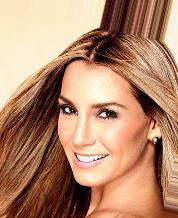

In [7]:
Image.open(files[0])

We need to remove pictures from profile faces and crop all of them only to keep the faces

## Cropping the dataset to only faces

In [5]:
import cv2

In [6]:
FACE_FILE = 'C:/git/models/opencv_models/haarcascades/haarcascade_frontalface_default.xml'

##### Define helper functions

In [7]:
def detect_face(img,cascade_classifier = None):
    if cascade_classifier is None:
        cascade_classifier = cv2.CascadeClassifier(FACE_FILE)
    faces = cascade_classifier.detectMultiScale(img, 1.3, 5)
    return faces

def crop_face(img,cascade_classifier = None):
    faces = detect_face(img,cascade_classifier = cascade_classifier)
    if len(faces) == 0:
        return None
    else:
        x,y,w,h = faces[0]
        return img[y:y+h, x:x+w]

def draw_face_contours(img,cascade_classifier = None):
    faces = detect_face(img,cascade_classifier = cascade_classifier)
    color = (255,0,0)

    new_img = img.copy()

    for (x,y,w,h) in faces:
        cv2.rectangle(new_img,(x,y),(x+w,y+h),color,2)

    return new_img

##### Test on a good image

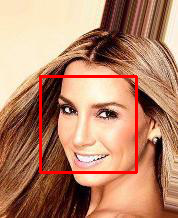

In [8]:
array1 = np.array(Image.open(files[0]))

Image.fromarray(draw_face_contours(array1))

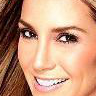

In [9]:
array1 = np.array(Image.open(files[0]))

Image.fromarray(crop_face(array1))

##### Test on a profile image

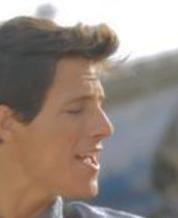

In [10]:
array2 = np.array(Image.open(files[2]))

Image.fromarray(draw_face_contours(array2))

In [11]:
array2 = np.array(Image.open(files[2]))

crop_face(array2) is None

True

## Creating the dataset

In [14]:
stack = []

for i,file in enumerate(tqdm(files)):
    array = np.array(Image.open(file))
    array = crop_face(array)
    if array is None:
        continue
    elif len(array.shape) < 3:
        continue
    else:
        array = np.array(Image.fromarray(array).resize((100,100)))
        array = np.expand_dims(array,axis = 0)
        stack.append(array)
        
    if len(stack) == 10000:
        break
        
X_train = np.vstack(stack)

 39%|██████████████                      | 11470/29252 [10:00<15:30, 19.10it/s]

In [6]:
X_train.shape

(10000, 100, 100, 3)

##### Storing the images processed in a numpy file .npy

In [17]:
np.save("X_train.npy",X_train)

In [5]:
X_train = np.load("X_train.npy")

## Visualize the images

In [20]:
def plot_sample(images,n_row=5, n_col=10):
    """
    Helper function to plot a gallery of images
    """
    
    # Random selection
    selection = np.random.randint(0,len(images),n_row*n_col)
    selection = images[selection]
    
    # Plot figure
    plt.figure(figsize=(1 * n_col, 1 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(selection[i],interpolation="nearest",cmap='Greys')
        plt.xticks(())
        plt.yticks(())

##### Sample images from the dataset

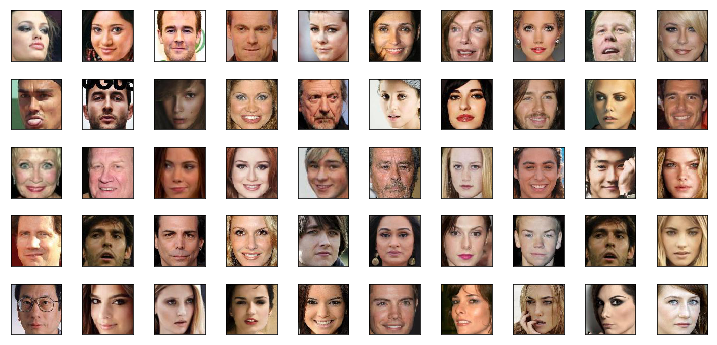

In [21]:
plot_sample(X_train)

***
# Creating a Variational Autoencoder with Keras


##### Libraries

In [7]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics

Using TensorFlow backend.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

##### Parameters

In [9]:
batch_size = 100
original_dim = 30000
latent_dim = 2
intermediate_dim = 1024
epochs = 50
epsilon_std = 1.0

## Preprocessing the dataset
- Divide by 255
- Flatten the dataset

In [10]:
X_train = X_train.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))

## Creating the VAE model

##### Creating the encoder

In [11]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

##### Sampling function

In [12]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

##### Creating the decoder

In [13]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

##### Custom Loss Layer

In [14]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

##### Instantiating the VAE model

In [15]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='adam', loss=None)

C:\Users\talvesdacosta\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  app.launch_new_instance()


## Train the VAE

In [16]:
from keras_tqdm import TQDMNotebookCallback
callback = TQDMNotebookCallback(leave_inner=True,leave_outer=True)

##### Training

In [ ]:
vae.fit(X_train,
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        # callbacks = [callback],
        verbose = 1,
       )

Epoch 1/50
10000/10000 [==============================] - ETA: 101s - loss: 20149.761 - ETA: 100s - loss: 20097.305 - ETA: 98s - loss: 20135.442 - ETA: 98s - loss: 20105.76 - ETA: 98s - loss: 20059.86 - ETA: 97s - loss: 20015.62 - ETA: 97s - loss: 19992.84 - ETA: 96s - loss: 19983.36 - ETA: 95s - loss: 19954.32 - ETA: 94s - loss: 19934.11 - ETA: 93s - loss: 19921.59 - ETA: 92s - loss: 19913.86 - ETA: 91s - loss: 19898.45 - ETA: 89s - loss: 19906.95 - ETA: 88s - loss: 19900.64 - ETA: 87s - loss: 19905.22 - ETA: 86s - loss: 19896.17 - ETA: 85s - loss: 19895.69 - ETA: 84s - loss: 19889.45 - ETA: 83s - loss: 19888.42 - ETA: 81s - loss: 19878.27 - ETA: 80s - loss: 19876.42 - ETA: 79s - loss: 19868.15 - ETA: 78s - loss: 19864.96 - ETA: 77s - loss: 19865.43 - ETA: 76s - loss: 19859.75 - ETA: 75s - loss: 19850.03 - ETA: 74s - loss: 19842.87 - ETA: 73s - loss: 19834.05 - ETA: 72s - loss: 19826.95 - ETA: 71s - loss: 19820.08 - ETA: 70s - loss: 19819.48 - ETA: 68s - loss: 19820.33 - ETA: 67s - lo

***
# Visualizing the results

## Visualizing the products generated on the latent space

##### Build a fashion generator that can sample from the learned distribution

In [45]:
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

##### Display the generated results

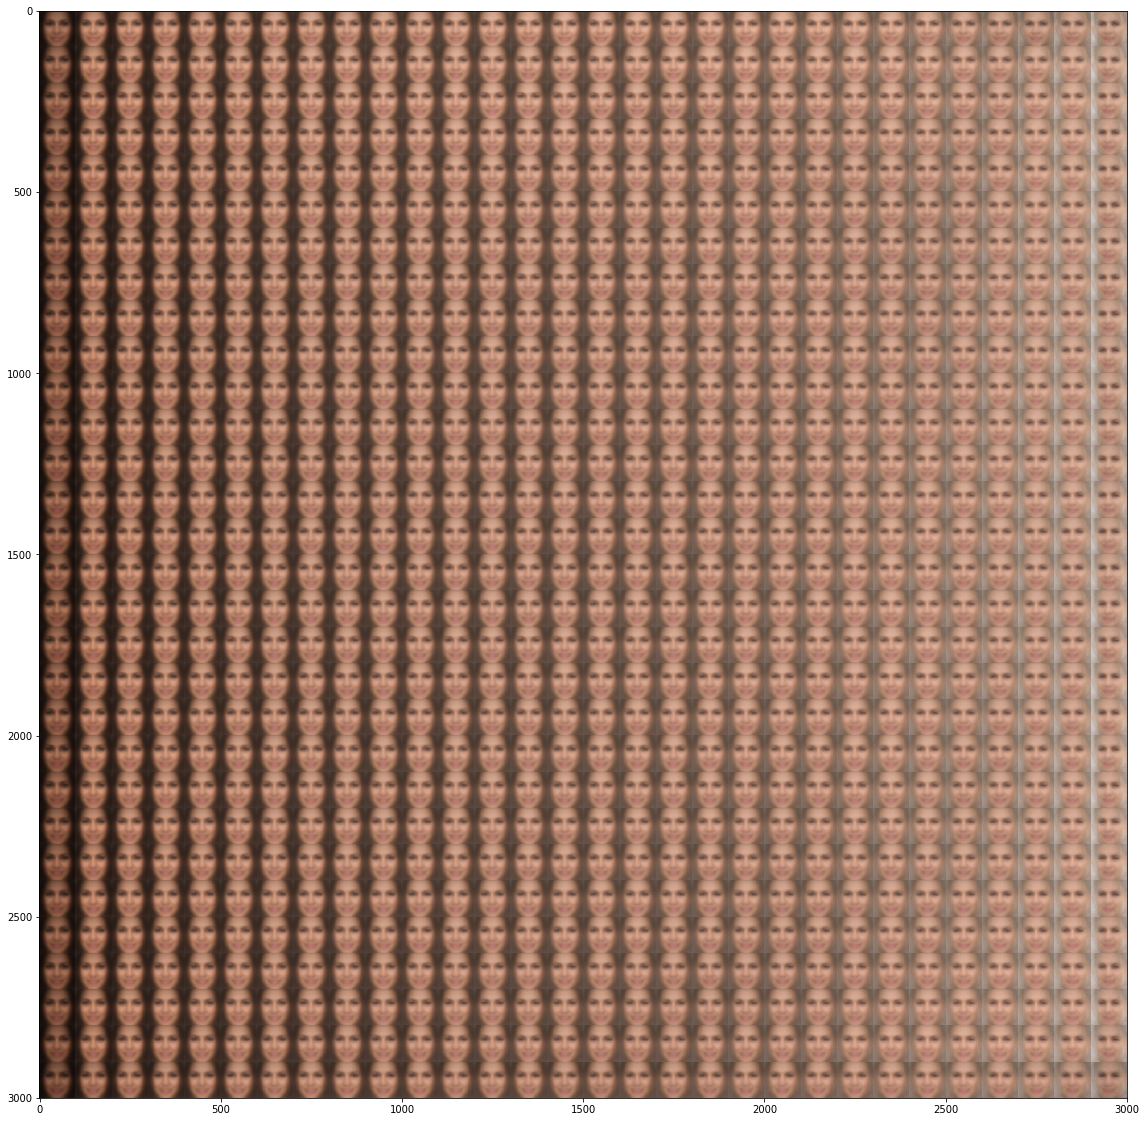

In [53]:
n = 30  
digit_size = 100
figure = np.zeros((digit_size * n, digit_size * n,3))

# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.01, 0.99, n))
grid_y = norm.ppf(np.linspace(0.01, 0.99, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        x_decoded = np.multiply(x_decoded,255)
        digit = x_decoded[0].reshape(digit_size, digit_size,3)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20,20))
plt.imshow(figure, cmap='Greys_r')
plt.show()